In [ ]:
import tensorflow as tf
print(tf.__version__)

1.19.5


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [ ]:
# Import Dataset
import json
with open('dataset.json') as json_data:
    intents = json.load(json_data)

In [ ]:
# Delete punctuation mark and lowing the text
import re
def string_preprocessing(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text.lower()

In [ ]:
#Labelling data
inputs, targets = [], []
labels = []
response_for_every_label = {}

for intent in intents['intents']:
    if intent['intent'] not in labels:
        labels.append(intent['intent'])
    if intent['intent'] not in response_for_every_label:
        response_for_every_label[intent['intent']] = []
        
    for text in intent['utterances']:
        inputs.append(string_preprocessing(text))
        targets.append(intent['intent'])
        
    for response in intent['answers']:
        response_for_every_label[intent['intent']].append(response)

In [ ]:
# Tokenizing data
vocab_size = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(inputs)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(inputs)
max_length = np.max([len(d) for d in training_sequences]) + 5
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# Saving tokenizing preprocessing
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

array([[ 4,  0,  0, ...,  0,  0,  0],
       [ 4,  6,  0, ...,  0,  0,  0],
       [33,  4,  0, ...,  0,  0,  0],
       ...,
       [ 5,  9,  0, ...,  0,  0,  0],
       [ 2, 25,  0, ...,  0,  0,  0],
       [ 5,  9,  0, ...,  0,  0,  0]], dtype=int32)

In [ ]:
# Creating target/label tensor
word={}
categorical_target=[]
counter=0
for trg in targets:
    if trg not in word:
        word[trg]=counter
        counter+=1
    categorical_target.append(word[trg])
    
    target_tensor = ku.to_categorical(categorical_target, num_classes=len(word), dtype='int32')
    target_index_word =  dict((v,k) for k, v in word.items())

In [ ]:
# Tuning hyperparameter
total_words = len(tokenizer.word_index) + 1
embedding_dim = 512
epochs = 100
output_node = target_tensor.shape[1]

In [ ]:
# Creating model
model = Sequential()
model.add(Embedding(total_words, embedding_dim))
model.add(Bidirectional(LSTM(512, return_sequences = True)))
model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(total_words, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(total_words/4, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(output_node, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 512)         35840     
_________________________________________________________________
bidirectional (Bidirectional (None, None, 1024)        4198400   
_________________________________________________________________
dropout (Dropout)            (None, None, 1024)        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               1311744   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 70)                17990     
_________________________________________________________________
dropout_2 (Dropout)          (None, 70)               

In [ ]:
# Training model
history = model.fit(training_padded, target_tensor, epochs=epochs, verbose=1)

Epoch 1/100
3/3 [==============================] - 7s 661ms/step - loss: 2.9576 - accuracy: 0.2326
Epoch 2/100
3/3 [==============================] - 2s 693ms/step - loss: 2.8964 - accuracy: 0.2093
Epoch 3/100
3/3 [==============================] - 2s 658ms/step - loss: 2.8149 - accuracy: 0.2209
Epoch 4/100
3/3 [==============================] - 2s 642ms/step - loss: 2.7497 - accuracy: 0.2326
Epoch 5/100
3/3 [==============================] - 2s 657ms/step - loss: 2.6740 - accuracy: 0.3256
Epoch 6/100
3/3 [==============================] - 2s 650ms/step - loss: 2.6299 - accuracy: 0.2674
Epoch 7/100
3/3 [==============================] - 2s 655ms/step - loss: 2.5465 - accuracy: 0.3372
Epoch 8/100
3/3 [==============================] - 2s 663ms/step - loss: 2.3949 - accuracy: 0.3953
Epoch 9/100
3/3 [==============================] - 2s 654ms/step - loss: 2.1361 - accuracy: 0.4884
Epoch 10/100
3/3 [==============================] - 2s 656ms/step - loss: 2.0064 - accuracy: 0.5233
Epoch 11/

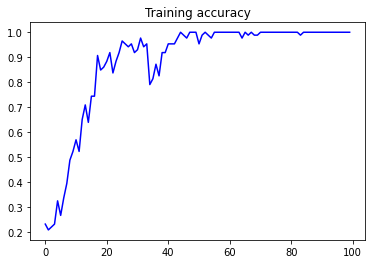

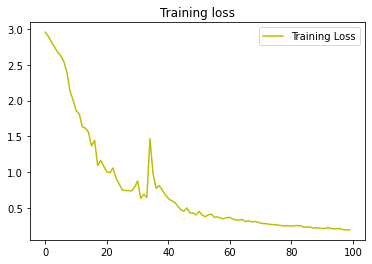

In [ ]:
# Plotting accuracy and loss
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'y', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
# Inference
text = "min saya kehilangan ktp"
seq =  tokenizer.texts_to_sequences([text])
pad = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
predicted = np.argmax(model.predict(pad, verbose=0))
predicted

4

In [ ]:
!pip install tensorflowjs

In [ ]:
# Saving ML model
import time
saved_model_path = "./{}.h5".format(int(time.time()))

model.save(saved_model_path)

In [ ]:
# Import model ke json
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

2021-05-31 02:50:56.430745: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
